https://huggingface.co/CompVis/ldm-celebahq-256

**Cross attention概念**

1.   Transformer架構中混合兩種不同嵌入序列的注意機制
2.   兩個序列必須具有相同的維度
3.   兩個序列可以是不同的模式形態（如：文本、聲音、圖像）
4.   一個序列作為輸入的Q，定義了輸出的序列長度，另一個序列提供輸入的K&V

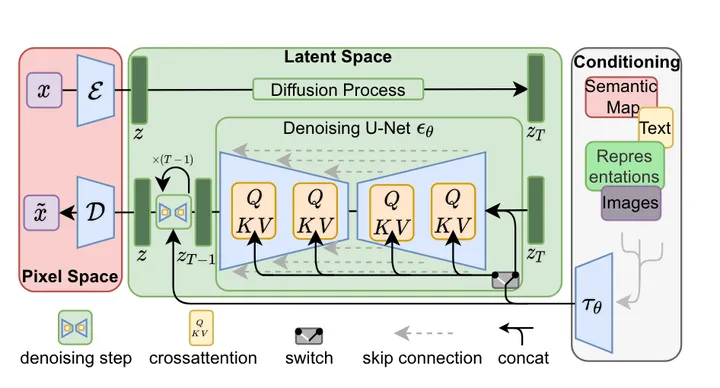

1.Encoder(右邊): 處理輸入的資料（如：文本、聲音、圖像）

2.生成模型(中間): Diffusion Model

3.Decoder(左邊): 把Diffusion Model生出來的中間產物, 一個圖片壓縮後的版本, 還原回原來的圖片

**Diffusion Process (Forward)**

**Diffusion Process (Backward)**

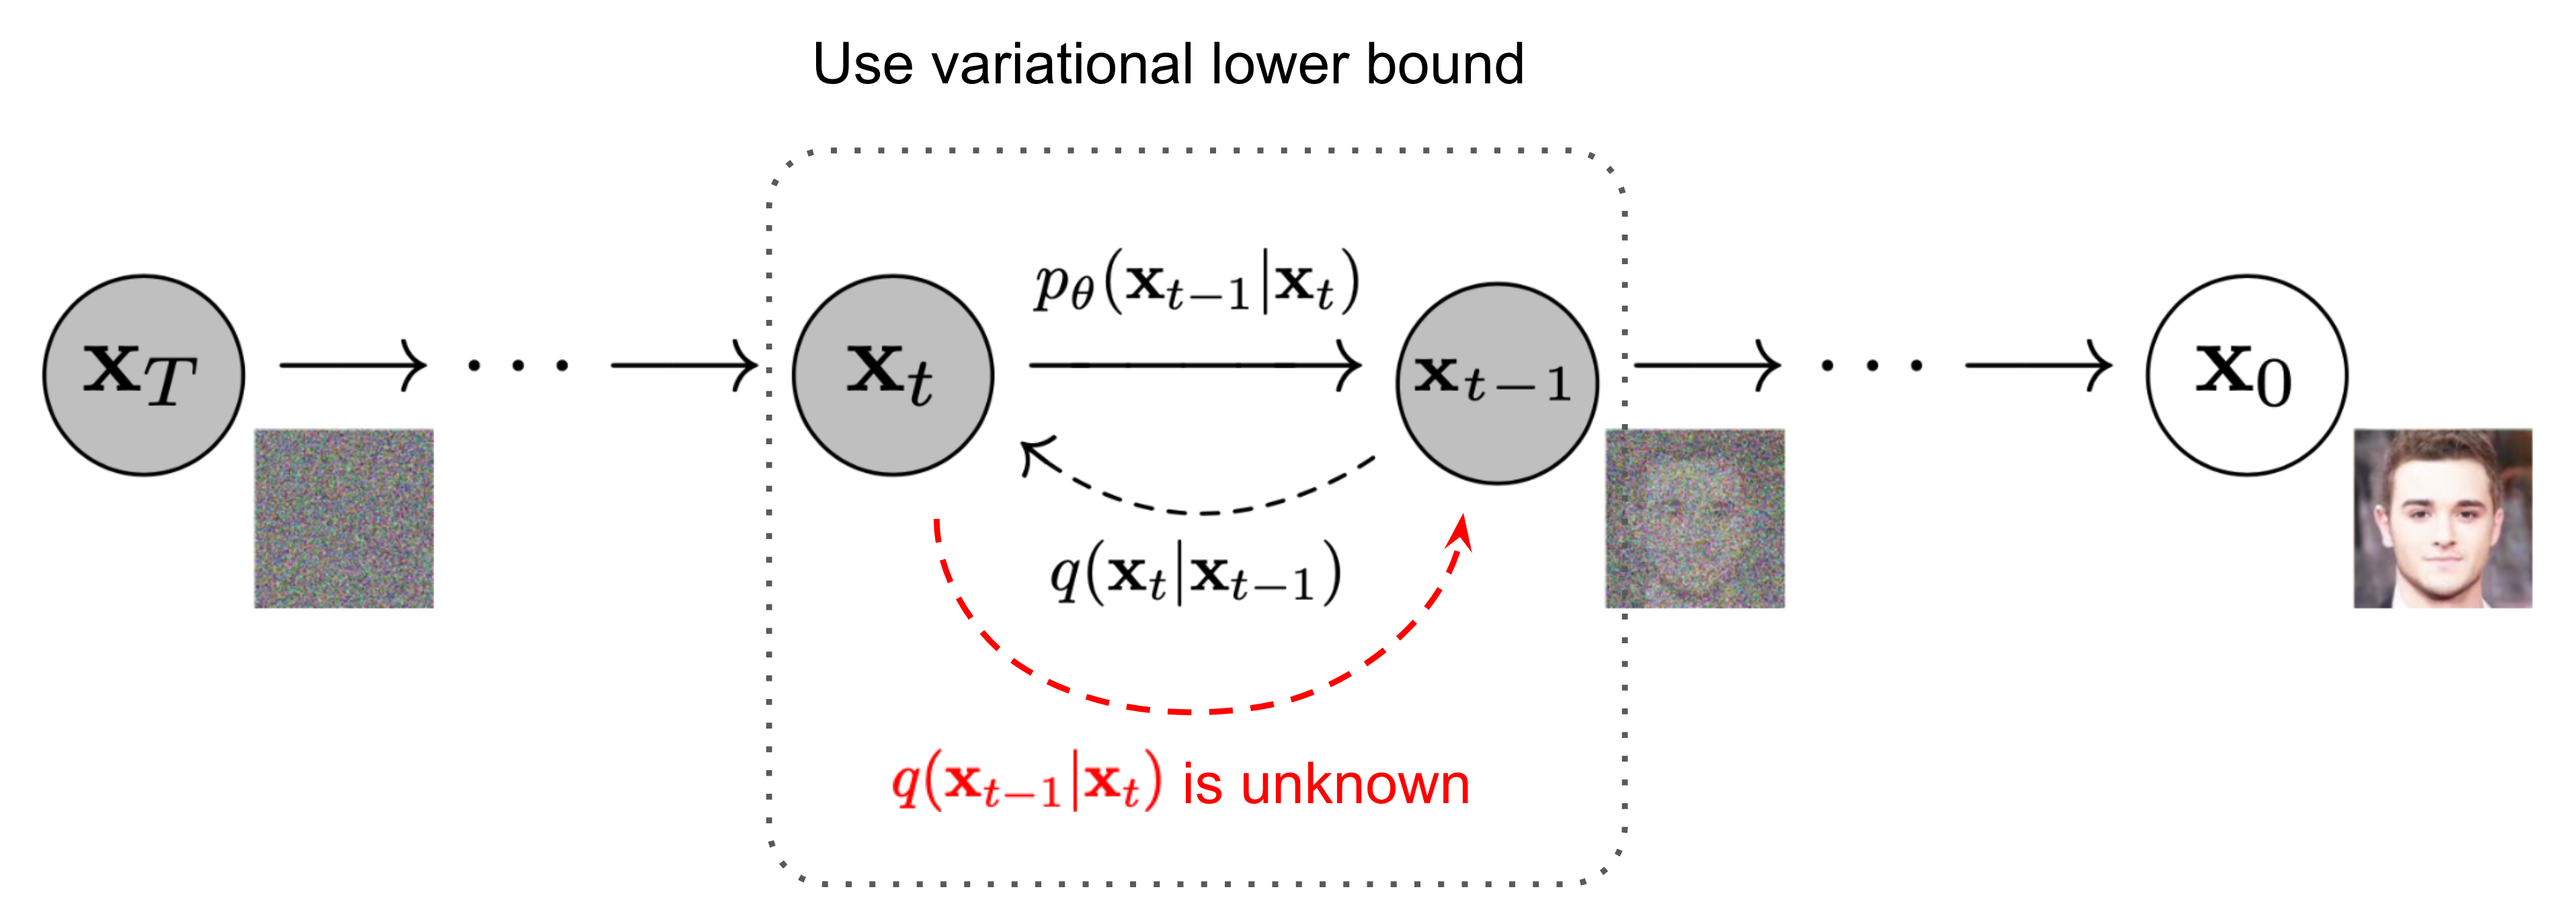

https://github.com/CompVis/latent-diffusion

In [ ]:
!pip install diffusers
from diffusers import DiffusionPipeline

model_id = "CompVis/ldm-celebahq-256"

# load model and scheduler
pipeline = DiffusionPipeline.from_pretrained(model_id)

# run pipeline in inference (sample random noise and denoise)
image = pipeline(num_inference_steps=200)["sample"]

# save image
image[0].save("ldm_generated_image.png")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/200 [00:00<?, ?it/s]

KeyError: ignored

In [ ]:
!pip install diffusers
from diffusers import UNet2DModel, DDIMScheduler, VQModel
import torch
import PIL.Image
import numpy as np
import tqdm

seed = 3

# load all models
unet = UNet2DModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="unet")
vqvae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")
scheduler = DDIMScheduler.from_config("CompVis/ldm-celebahq-256", subfolder="scheduler")

# set to cuda
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

unet.to(torch_device)
vqvae.to(torch_device)

# generate gaussian noise to be decoded
generator = torch.manual_seed(seed)
noise = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

# set inference steps for DDIM
scheduler.set_timesteps(num_inference_steps=200)

image = noise
for t in tqdm.tqdm(scheduler.timesteps):
    # predict noise residual of previous image
    with torch.no_grad():
        residual = unet(image, t)["sample"]

    # compute previous image x_t according to DDIM formula
    prev_image = scheduler.step(residual, t, image, eta=0.0)["prev_sample"]

    # x_t-1 -> x_t
    image = prev_image

# decode image with vae
with torch.no_grad():
    image = vqvae.decode(image)

# process image
image_processed = image.cpu().permute(0, 2, 3, 1)
image_processed = (image_processed + 1.0) * 127.5
image_processed = image_processed.clamp(0, 255).numpy().astype(np.uint8)
image_pil = PIL.Image.fromarray(image_processed[0])

image_pil.save(f"generated_image_{seed}.png")